### Treinamento do Modelo Machine Learning

In [ ]:
%pip install pandas scikit-learn xgboost joblib

### Importações de Bibliotecas

In [2]:
# Data load and processing
import pandas as pd
import numpy as np
from typing import List, Tuple
import boto3
from io import StringIO
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

In [1]:
## Pre-Processing and evaluation
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score
from sklearn.inspection import permutation_importance
from yellowbrick.features import FeatureImportances

In [3]:
# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import dump

#### Instruções

1. Renomear o arquivo .env_exemplo para somente .env
2. Adicionar popular as variaveis conforme o padrão de nomenclatura que voce utilizar

### Reading the Data

In [5]:
load_dotenv()
def read_from_s3(bucket_name:str):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    response = []
    for obj in bucket.objects.all():
        body = obj.get()['Body'].read()
        s=str(body,'utf-8')
        data = StringIO(s)
        response.append(pd.read_csv(data, index_col=0))
    return response

In [7]:
bucket_name = os.environ['BUCKET_NAME']
csv_file_name = 'btc_2.csv'
bucket_layer = os.environ['BUCKET_LAYER']
object_name = f'{bucket_layer}/{csv_file_name}'
data = read_from_s3(bucket_name)
#data.head()

In [8]:
load_dotenv()
s3_client = boto3.client('s3')
bucket_name = os.environ['BUCKET_NAME']
csv_file_name = os.environ['CSV_FILE_NAME']
bucket_layer = os.environ['BUCKET_LAYER']
object_name = f'{bucket_layer}/{csv_file_name}'

In [9]:
csv_obj = s3_client.get_object(Bucket=bucket_name, Key=object_name)
csv_data = csv_obj['Body'].read().decode('utf-8')
data = pd.read_csv(StringIO(csv_data), index_col=0, parse_dates=[0])
# data.index = pd.to_datetime(data.index)

In [10]:
# If working with data, please uncoment this line for safety, this will generate a backup of the dataframe prior to pre-processing
df_backup = data.copy()

In [11]:
new_data = data.copy()

In [12]:
new_data.shape

(2418, 27)

### Data Pre-Processing

In [13]:
# Defining the predictors Columns
predictors: List[str] = ['low', 'close', 'sentiment', 'neg_sentiment', 'close_ratio_2', 'edit_2',
       'close_ratio_7', 'close_ratio_365', 'edit_365']

map = {'Neutral': 0, 'Greed': 1, 'Fear': -1, 'Extreme Fear': -2, 'Extreme Greed': 2}

std_scaler = StandardScaler()

In [71]:
# #Adjusting fng classification values
# def adjust_df_for_ml(df:pd.DataFrame, map:dict) -> pd.DataFrame:
#     df['fng_class_yest_adjusted'] = df['fng_class_yest'].map(map)
#     df.drop(columns=['fng_class', 'fng_class_yest'], axis=1, inplace=True)
#     return df

# ml_data = adjust_df_for_ml(df=new_data, map=map)
# ml_data.head()

Here we are going to test 3 approaches:

1. without any normalization or scalling
2. applying a normalization
3. applying scalling

In [22]:
# new_data = df_backup.copy()

In [14]:
#spliting data for gridsearch
stest = int(new_data.shape[0]*0.2)
l1 = new_data.shape[0] - stest
train = new_data.iloc[0:l1]
test = new_data.iloc[l1:]

## prepare x_train for models
X_train = train[predictors]
X_train_norm = normalize(train[predictors])
X_train_scaled = std_scaler.fit_transform(train[predictors])

## prepate x_test for models
X_test = test[predictors]
X_test_norm = normalize(test[predictors])
X_test_scaled = std_scaler.fit_transform(test[predictors])

## Target
y_train = train['target']
y_test = test['target']

### Running Grid Search CV to find best Model

In [15]:
def run_grid_search_cv(model, params, X, y):
    search_cv = GridSearchCV(model, params)
    search_cv.fit(X, y)
    return search_cv.best_score_, \
           search_cv.best_params_, \
           search_cv.best_estimator_

def print_grid_evaluation_report(best_score: float, best_params: dict) -> None:
    print("----Evaluation Report----\n")
    print(f"Best Score Achieved: {best_score}\n")
    print(f"Best Params Found: {best_params}\n")
    print("---------------------------------\n")

def predict(train: pd.DataFrame, test: pd.DataFrame, 
            predictors: List[str], model, mode:str= 'raw') -> pd.DataFrame:
    y_train = train["target"]
    X_train = train[predictors]
    X_test = test[predictors]
    
    if mode == 'norm':
        X_train = normalize(X_train)
        X_test = normalize(X_test)
    elif mode == 'sca':
        X_train = std_scaler.fit_transform(X_train)
        X_test = std_scaler.fit_transform(X_test)
    model.fit(X_train, y_train)
    # preds = model.predict(X_test)
    # Predict probabilities
    probabilities = model.predict_proba(X_test)

    # Extract probabilities for class 1
    class_1_probs = probabilities[:, 1]  # Assuming class 1 is the second column

    # Apply threshold
    predictions = (class_1_probs >= 0.55).astype(int)
    preds = pd.Series(predictions, index=test.index, name="predictions")
    return pd.concat([test["target"], preds], axis=1)

def backtest(data: pd.DataFrame, model, 
             predictors: List[str], start: int = 1095, # 3 years 
             step: int = 10, mode:str = 'raw') -> pd.DataFrame:
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model, mode)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

def evaluate_model(predictions: pd.DataFrame) -> Tuple[float, float]:
    precision = precision_score(predictions["target"], predictions["predictions"])
    accuracy = accuracy_score(predictions["target"], predictions["predictions"])
    return precision, accuracy

def plot_feature_importances(model, X:np.ndarray, y:np.ndarray, label:list) -> FeatureImportances:
    fig_viz = FeatureImportances(model, labels=predictors)
    fig_viz.fit(X, y)
    return fig_viz

#### Random Forest (RF)

In [17]:
rf_params = {
    'n_estimators':[100, 125, 150, 200, 220, 250],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [15],
    'n_jobs': [-1]

}
rf_model = RandomForestClassifier(random_state=1)

##### Random Forest (RF) raw

In [ ]:
best_score, best_params, best_model_rf_cr = run_grid_search_cv(model=rf_model, params=rf_params, X=X_train, y=y_train)
print_grid_evaluation_report(best_score, best_params)

In [ ]:
predictions = backtest(new_data, best_model_rf_cr, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

In [ ]:
predictions['target'].value_counts()

In [ ]:
predictions['predictions'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_rf_cr, 
                                              X=X_train, 
                                              y=y_train,
                                              label=predictors)
plt.show(feature_importance)

##### Random Forest (RF) Scaled

In [18]:
best_score, best_params, best_model_rf_sca = run_grid_search_cv(model=rf_model, params=rf_params, X=X_train_scaled, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.49302325581395345

Best Params Found: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 15, 'n_estimators': 100, 'n_jobs': -1}

---------------------------------



c:\Users\I857413\Desktop\TechSkills\Forks\bitcoin_trend_prediction\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [19]:
predictions = backtest(new_data, best_model_rf_sca, predictors, mode='sca')

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.60
Acurácia do modelo: 0.59
            target  predictions
2021-02-04       1            1
2021-02-05       1            1
2021-02-06       0            1
2021-02-07       1            1
2021-02-08       1            0
...            ...          ...
2024-09-14       0            1
2024-09-15       0            1
2024-09-16       1            1
2024-09-17       1            0
2024-09-18       1            1

[1323 rows x 2 columns]


In [20]:
predictions['target'].value_counts()

target
0    668
1    655
Name: count, dtype: int64

In [21]:
predictions['predictions'].value_counts()

predictions
0    735
1    588
Name: count, dtype: int64

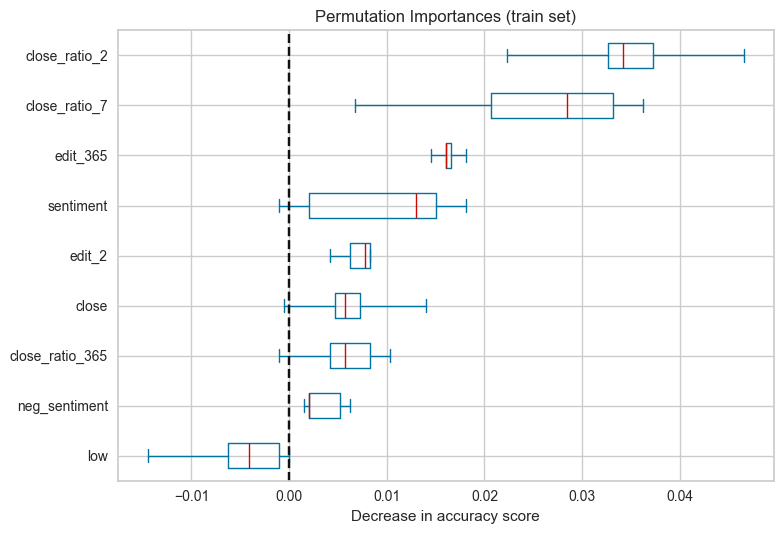

In [17]:
result = permutation_importance(
    best_model_rf_sca, X_train_scaled, y_train)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=new_data[predictors].columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

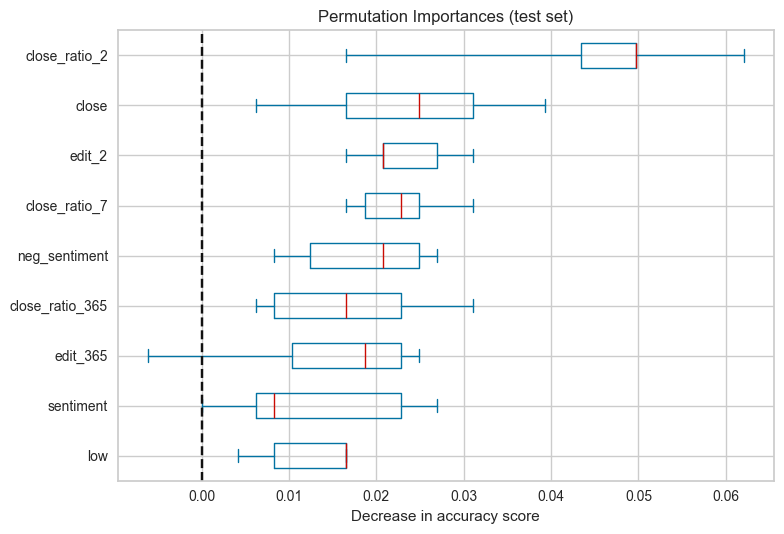

In [22]:
result = permutation_importance(
    best_model_rf_sca, X_test_scaled, y_test)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=new_data[predictors].columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [23]:
print(f"RF train accuracy: {best_model_rf_sca.score(X_train_scaled, y_train):.3f}")
print(f"RF test accuracy: {best_model_rf_sca.score(X_test_scaled, y_test):.3f}")

RF train accuracy: 0.616
RF test accuracy: 0.549


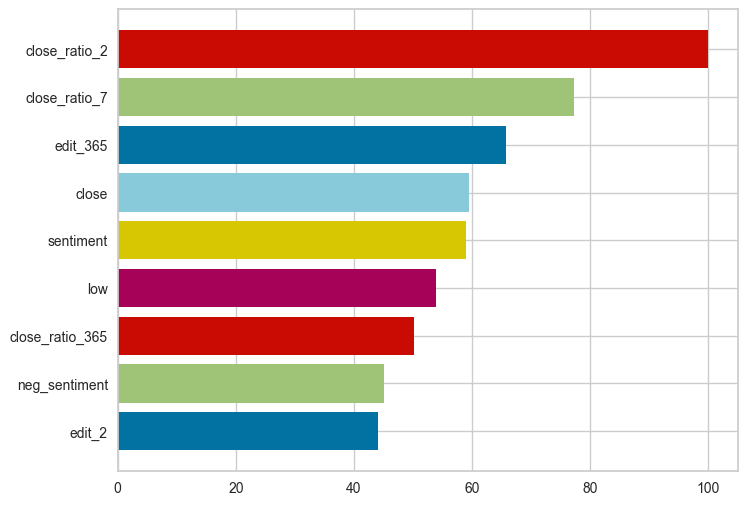

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_rf_sca, 
                                              X=X_train_scaled, 
                                              y=y_train, 
                                              label = predictors)
plt.show(feature_importance)

##### Random Forest (RF) Normalized

In [ ]:
best_score, best_params, best_model_rf_norm = run_grid_search_cv(model=rf_model, params=rf_params, X=X_train_norm, y=y_train)
print_grid_evaluation_report(best_score, best_params)

In [ ]:
predictions = backtest(new_data, best_model_rf_norm, predictors, mode='norm')

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

In [ ]:
predictions['target'].value_counts()

In [ ]:
predictions['predictions'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_rf_norm, 
                                              X=X_train_norm, 
                                              y=y_train, 
                                              label = predictors)
plt.show(feature_importance)

#### KNN Classifier

In [157]:
knn_params = {
    'n_neighbors':[5,7,9,10,11,12,13,14, 30, 60],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
}
knn_model = KNeighborsClassifier()

##### KNN Classifier Raw

In [ ]:
best_score, best_params, best_model_knn_cr = run_grid_search_cv(model=knn_model, params=knn_params, X=X_train, y=y_train)
print_grid_evaluation_report(best_score, best_params)

In [ ]:
predictions = backtest(new_data, best_model_knn_cr, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

In [ ]:
predictions['target'].value_counts()

In [ ]:
predictions['predictions'].value_counts()

##### KNN Classifier Scaled

In [ ]:
best_score, best_params, best_model_knn_sca = run_grid_search_cv(model=knn_model, params=knn_params, X=X_train_scaled, y=y_train)
print_grid_evaluation_report(best_score, best_params)

In [ ]:
predictions = backtest(new_data, best_model_knn_sca, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

In [ ]:
predictions['target'].value_counts()

In [ ]:
predictions['predictions'].value_counts()

##### KNN Classifier Normalized

In [ ]:
best_score, best_params, best_model_knn_norm = run_grid_search_cv(model=knn_model, params=knn_params, X=X_train_norm, y=y_train)
print_grid_evaluation_report(best_score, best_params)

In [ ]:
predictions = backtest(new_data, best_model_knn_norm, predictors, mode='norm')

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

In [ ]:
predictions['target'].value_counts()

In [ ]:
predictions['predictions'].value_counts()

#### XGBoost

In [162]:
xgb_params = {'random_state' : [1], 
              'learning_rate' : [0.1, 0.2, 0.3, 0.4], 
              'n_estimators' : [100,150,200,250,300], 
              'colsample_bytree' : [0.25, 0.5, 0.75, 1], 
              'max_depth' : [3,5,6,7,8]
}

model_xgb = XGBClassifier()

##### XGBoost Raw

In [ ]:
best_score, best_params, best_model_xgb_cr = run_grid_search_cv(model=model_xgb, params=xgb_params, X=X_train, y=y_train)
print_grid_evaluation_report(best_score, best_params)

In [ ]:
predictions = backtest(new_data, best_model_xgb_cr, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

In [ ]:
predictions['target'].value_counts()

In [ ]:
predictions['predictions'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_xgb_cr, 
                                              X=X_train, 
                                              y=y_train,
                                              label=predictors)
plt.show(feature_importance)

##### XGBoost Scaled

In [ ]:
best_score, best_params, best_model_xgb_sca = run_grid_search_cv(model=model_xgb, params=xgb_params, X=X_train_scaled, y=y_train)
print_grid_evaluation_report(best_score, best_params)

In [ ]:
predictions = backtest(new_data, best_model_xgb_sca, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

In [ ]:
predictions['target'].value_counts()

In [ ]:
predictions['predictions'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_xgb_sca, 
                                              X=X_train_scaled, 
                                              y=y_train,
                                              label=predictors)
plt.show(feature_importance)

##### XGBoost Norm

In [ ]:
best_score, best_params, best_model_xgb_norm = run_grid_search_cv(model=model_xgb, params=xgb_params, X=X_train_norm, y=y_train)
print_grid_evaluation_report(best_score, best_params)

In [ ]:
predictions = backtest(new_data, best_model_xgb_norm, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

In [ ]:
predictions['target'].value_counts()

In [ ]:
predictions['predictions'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_xgb_norm, 
                                              X=X_train_norm, 
                                              y=y_train,
                                              label=predictors)
plt.show(feature_importance)

### Running Best Model

In [25]:
# # Função de predição
# def predict(train: pd.DataFrame, test: pd.DataFrame, predictors: List[str], model: XGBClassifier) -> pd.DataFrame:
#     model.fit(train[predictors], train["target"])
#     preds = model.predict(test[predictors])
#     preds = pd.Series(preds, index=test.index, name="predictions")
#     return pd.concat([test["target"], preds], axis=1)

# # Função de backtesting
# # Usaremos uma abordagem de janela móvel para fazer o backtesting do modelo.
# # Pegaremos uma janela de dados, usaremos para treinar o modelo e, em seguida, usaremos o modelo para prever a próxima janela de dados.
# # Repetiremos esse processo até termos usado todos os dados.
# # O parâmetro start significa 3 anos de dados para treinar o modelo.
# # O parâmetro step significa 150 dias de dados para testar o modelo.
# def backtest(data: pd.DataFrame, model: XGBClassifier, predictors: List[str], start: int = 1095, step: int = 150) -> pd.DataFrame:
#     all_predictions = []

#     for i in range(start, data.shape[0], step):
#         train = data.iloc[0:i].copy()
#         test = data.iloc[i:(i + step)].copy()
#         predictions = predict(train, test, predictors, model)
#         all_predictions.append(predictions)

#     return pd.concat(all_predictions)

# # Função de avaliação do modelo
# def evaluate_model(predictions: pd.DataFrame) -> Tuple[float, float]:
#     precision = precision_score(predictions["target"], predictions["predictions"])
#     accuracy = accuracy_score(predictions["target"], predictions["predictions"])
#     return precision, accuracy

In [ ]:
# # Criar e treinar o modelo XGBoost
# model = XGBClassifier(random_state=1, learning_rate=0.2, n_estimators=500, colsample_bytree = 1, max_depth = 8)
# predictions = backtest(data, model, predictors)

# # Avaliar o modelo
# precision, accuracy = evaluate_model(predictions)
# print(f"Precisão do modelo: {precision:.2f}")
# print(f"Acurácia do modelo: {accuracy:.2f}")
# print(predictions)

In [ ]:
data.info()

### Serialização do Modelo

In [25]:
# Salvar o modelo treinado em um arquivo
scaler_filename = "scaler.joblib"
model_filename = "btc_trend_prediction_model_best.joblib"
dump(best_model_rf_sca, model_filename)
dump(std_scaler, scaler_filename)

['scaler.joblib']